# Factor analysis of my portfolio

In [15]:
import numpy as np
import pandas as pd
from openbb import obb
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels import regression
obb.user.preferences.output_type = "dataframe"

In [16]:
symbols = ["TSLA", "AMZN", "NVDA", "NOVO-B.CO", "BAVA.CO", "DANSKE.CO", "SXLC.L", "SXLP.L", "SXLK.L"]

start = "2024-11-15"
end = "2025-02-15"

data = obb.equity.price.historical(
    symbols,
    start_date=start,
    end_date=end,
    provider="yfinance").pivot(columns="symbol", values="close")

returns = data.pct_change(fill_method=None).dropna()
display(returns.head())

symbol,AMZN,BAVA.CO,DANSKE.CO,NOVO-B.CO,NVDA,SXLC.L,SXLK.L,SXLP.L,TSLA
date,,,,,,,,,
2024-11-18,-0.004491,0.095801,0.008768,-0.006610,-0.012889,0.004346,0.004913,0.004739,0.056186
2024-11-19,0.014427,0.026174,-0.012554,0.026476,0.048948,0.003901,-0.003350,0.004445,0.021432
2024-11-20,-0.008455,0.015251,0.003423,0.018069,-0.007618,0.002368,-0.006554,-0.009994,-0.011474
2024-11-21,-0.022181,-0.003108,-0.008285,-0.022084,0.005346,-0.003331,0.020761,0.017149,-0.006988
2024-11-22,-0.006351,0.030917,-0.007862,0.040316,-0.032181,0.002188,-0.003388,0.011389,0.038040


## Principal Component Analysis

In [17]:
pca = PCA(n_components=3)
pca.fit(returns)
pct = pca.explained_variance_ratio_
pca_components = pca.components_

(0.0, 100.0)

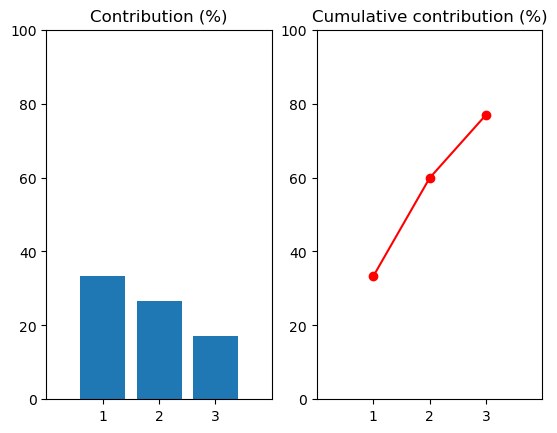

In [18]:
cum_pct = np.cumsum(pct)
x = np.arange(1, len(pct) + 1, 1)
plt.subplot(1,2,1)
plt.bar(x, pct * 100, align="center")
plt.title("Contribution (%)")
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])
plt.subplot(1,2,2)
plt.plot(x, cum_pct * 100, "ro-")
plt.title("Cumulative contribution (%)")
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

## New Features

In [19]:
X = np.asarray(returns)
factor_returns = X.dot(pca_components.T)
factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3"],
    index=returns.index,
    data=factor_returns
)

display(factor_returns.head())

,f1,f2,f3
date,,,
2024-11-18,0.047936,0.010597,0.041102
2024-11-19,0.059008,0.001803,-0.018595
2024-11-20,-0.007018,0.016512,-0.015288
2024-11-21,-0.006782,-0.024980,-0.000484
2024-11-22,0.018175,0.057065,0.021648


In [20]:
factor_exposures = pd.DataFrame(
    index=["f1", "f2", "f3"],
    columns=returns.columns,
    data=pca_components
).T

display(factor_exposures)
display(factor_exposures.values[[2, 5, 7], 0])

,f1,f2,f3
symbol,,,
AMZN,0.178909,-0.000461,0.167029
BAVA.CO,0.227168,-0.031784,-0.053007
DANSKE.CO,0.023885,0.057697,-0.125942
NOVO-B.CO,0.242733,0.831206,-0.481247
NVDA,0.641317,-0.490918,-0.487584
SXLC.L,0.053148,0.033771,0.045600
SXLK.L,0.218298,-0.109321,-0.089900
SXLP.L,0.003464,0.018611,0.047209
TSLA,0.628584,0.224318,0.686807


array([0.02388539, 0.0531484 , 0.00346354])

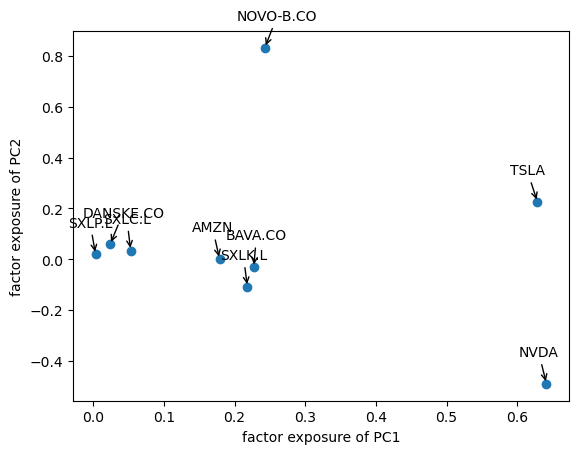

In [21]:
labels = factor_exposures.index
data = factor_exposures.values
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel("factor exposure of PC1")
plt.ylabel("factor exposure of PC2")
for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x,y),
        xytext=(-20,20),
        textcoords="offset points",
        arrowprops=dict(
            arrowstyle="->",
            connectionstyle="arc3, rad=0"
        ),
    )

DANSKE.CO, XLP.L and XLC.L seem to cluster together around the same level of exposure in both factors, and are apparently relatively unaffected by these factors. The first part can also be said for AMZN, BAVA.CO and SXLK.L, although this cluster is more exposed to factor 1. NOVO-B.CO has around as much exposure to factor 1 as the precious cluster, but is much more exposed to factor 2, much more than any other stock in the portfolio. Lastly, TSLA and NVDA have around the same high exposure to factor 1, but are almost symmetrically distributed around the zero point of factor 2.

The two clusters almost balance out their risks in factor 1 and reduce it to a level of 0.1. Likewise, TSLA and NVDA seem to hedge each other in their exposure to factor 2, but the portfolio might benefit from some negative exposure to factor 1 in order to hedge the risk coming from these two stocks. NOVO-B.CO doesn't add more exposure to factor 1 given the second cluster, but is extreme exposure to factor 2 is not offset by anything in this portfolio.

## Hedging beta

In [93]:
symbols = ["TSLA", "AMZN", "NVDA", "NOVO-B.CO", "BAVA.CO", "DANSKE.CO", "SXLC.L", "SXLP.L", "SXLK.L", "SPY"]

data = obb.equity.price.historical(
    symbols,
    start_date=start,
    end_date=end,
    provider="yfinance").pivot(columns="symbol", values="close").dropna()

benchmark_returns = (
    data
    .pop("SPY")
    .pct_change()
    .dropna()
)

portfolio_returns = (
    data
    .pct_change()
    .dropna()
    .sum(axis=1)
)
display(benchmark_returns.size)
display(portfolio_returns.size)

portfolio_returns.name = "portfolio"
benchmark_returns.name = "SPY"

57

57

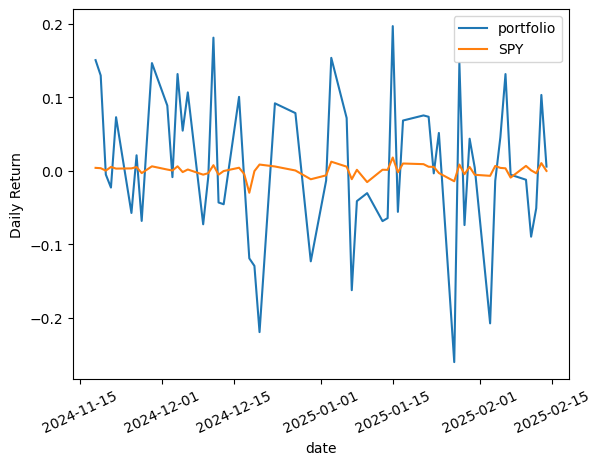

In [94]:
plt.clf()
portfolio_returns.plot()
benchmark_returns.plot(rot=25)
plt.ylabel("Daily Return")
plt.legend()

In [95]:
X = benchmark_returns.values
Y = portfolio_returns.values

def linreg(x, y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    x = x[:, 1]
    return model.params[0], model.params[1]

In [96]:
alpha, beta = linreg(X, Y)
print(f"Alpha: {alpha}")
print(f"Beta: {beta}")

Alpha: 0.0018362503244979595
Beta: 8.189569539251742


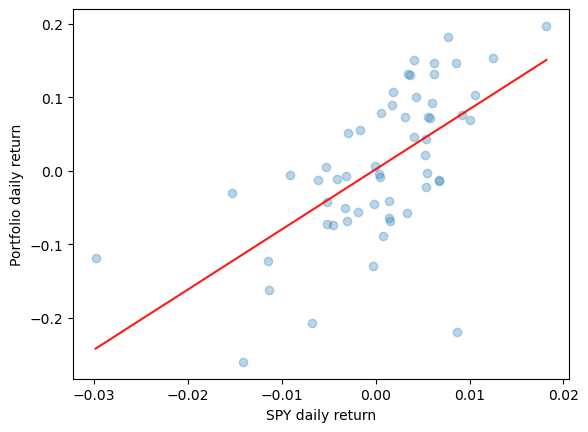

In [97]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha
plt.scatter(X, Y, alpha=0.3)
plt.xlabel("SPY daily return")
plt.ylabel("Portfolio daily return")
plt.plot(X2, Y_hat, "r", alpha=0.9)

In [98]:
hedged_portfolio_returns = -1 * beta * benchmark_returns + portfolio_returns

In [101]:
P = hedged_portfolio_returns.values
_, beta = linreg(X, P)
print(f"Beta: {beta}")

Beta: -1.7763568394002505e-15


In [102]:
def information_ratio(
    portfolio_returns,
    benchmark_returns
):
    active_return = portfolio_returns - benchmark_returns
    tracking_error = active_return.std()
    return active_return.mean() / tracking_error

In [103]:
hedged_ir = information_ratio(
    hedged_portfolio_returns,
    benchmark_returns
)

unhedged_ir = information_ratio(
    portfolio_returns,
    benchmark_returns
)

print(f"Hedged information ratio: {hedged_ir}")
print(f"Unhedged information ratio: {unhedged_ir}")

Hedged information ratio: 0.01378169821398645
Unhedged information ratio: 0.07308185836396025
